In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=150)

In [2]:
class rb():
    position = 10
    def __init__(self, position):
        self.position = position
    def apply(self, systemmatrix, rhs, delta_x):
        pass
class neumann(rb):
    waermestrom = 5
    def __init__(self, position, waermestrom):
        super(neumann,self).__init__(position)
        self.waermestrom = waermestrom
    def apply(self, systemmatrix, rhs, delta_x):
        if (self.position == 0):
            # Vorwärtsdifferenz
            systemmatrix[self.position, 0:2] = (1, -1)
        elif (self.position < len(rhs)):
            # Rückwärtsdifferenz
            systemmatrix[self.position, self.position-1:self.position+1] = (-1, 1)
        else:
            raise ValueError("Out of bounds")
        rhs[self.position] = rhs[self.position] + self.waermestrom * delta_x
class dirichlet(rb):
    temperatur = 5
    def __init__(self, position, temperatur):
        super(dirichlet,self).__init__(position)
        self.temperatur = temperatur
    def apply(self, systemmatrix, rhs, delta_x):
        if (self.position > len(rhs)):
            raise ValueError("Out of bounds")
        systemmatrix[self.position, self.position] = 1
        rhs[self.position] = rhs[self.position] + self.temperatur
class waermequelle(rb):
    staerke = 5
    kappa = 10
    def __init__(self, position, staerke):
        super(waermequelle,self).__init__(position)
        self.staerke = staerke
    def apply(self, systemmatrix, rhs, delta_x):
        rhs[self.position] = rhs[self.position] + self.staerke * delta_x**2 / self.kappa

In [3]:
def assemble(knoten, l, kappa, Pe, rben, zentraldifferenz):
    delta_x = l / (knoten-1)
    U = Pe * kappa / l
    systemmatrix = np.zeros((knoten, knoten))
    rhs = np.zeros((knoten))
    for i in range(1, knoten-1):
        systemmatrix[i, i-1:i+2] = kappa / delta_x**2 * np.array((-1, 2, -1))
        if (zentraldifferenz):
            systemmatrix[i, i-1:i+2] = systemmatrix[i, i-1:i+2] + 0.5 * U / delta_x * np.array((-1, 0, 1))
        else:
            systemmatrix[i, i-1:i+2] = systemmatrix[i, i-1:i+2] + np.array((-max(U, 0), - min(U, 0) + max(U, 0), min(U, 0)))/ delta_x
    for rb in rben:
        rb.apply(systemmatrix, rhs, delta_x)        
    return systemmatrix, rhs
def solve(knoten, l, kappa, Pe, rben, zentraldifferenz):
    systemmatrix, rhs = assemble(knoten, l, kappa, Pe, rben, zentraldifferenz)
    solution = np.linalg.solve(systemmatrix, rhs)
    return np.linspace(0, l, knoten), solution, systemmatrix, rhs

### Aufgabe 2.4.1
Beispiellösung und analytische Lösung:

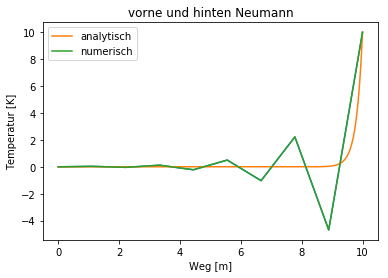

In [4]:
T_links = 0
T_rechts = 10
knoten = 10
Pe = 50
kappa = 10
l = 10
rb_vorne = dirichlet(0, T_links)
rb_hinten = dirichlet(knoten-1, T_rechts)
x, T1, s, r = solve(knoten, l, kappa, Pe, [rb_vorne, rb_hinten], True)
plt.plot(x, T1)
plt.title("vorne und hinten Neumann")
plt.xlabel("Weg [m]")
plt.ylabel("Temperatur [K]")
xan = np.linspace(0, 10, 201)
yan = [T_links + (np.exp(xv * Pe / l) - 1)/(np.exp(Pe) - 1) * (T_rechts - T_links) for xv in xan]
plt.plot(xan, yan, label="analytisch")
plt.plot(x, T1, label="numerisch")
plt.legend()
plt.show()

### Aufgabe 2.4.4. 

In [5]:
knotenzahlen = [11, 17, 26, 51, 101]
loesungen = []
yan = {}
for Pe in [5, 50]:
    yan[Pe] = [T_links + (np.exp(xv * Pe / l) - 1)/(np.exp(Pe) - 1) * (T_rechts - T_links) for xv in xan]
    for verfahren in  [True, False]:
        for knoten in knotenzahlen:
            rb_vorne = dirichlet(0, T_links)
            rb_hinten = dirichlet(knoten-1, T_rechts)
            x, T, s, r = solve(knoten, l, kappa, Pe, [rb_vorne, rb_hinten], verfahren)
            errors = []
            for value in zip(x, T):
                position_in_exact = (np.abs(xan-value[0])).argmin()
                exact = yan[Pe][position_in_exact]
                numeric = value[1]
                error = exact - numeric
                errors += [error]
            meanerror = sum(np.abs(errors))/knoten
            loesungen += [[Pe, knoten, verfahren, x, T, errors, meanerror]]
            

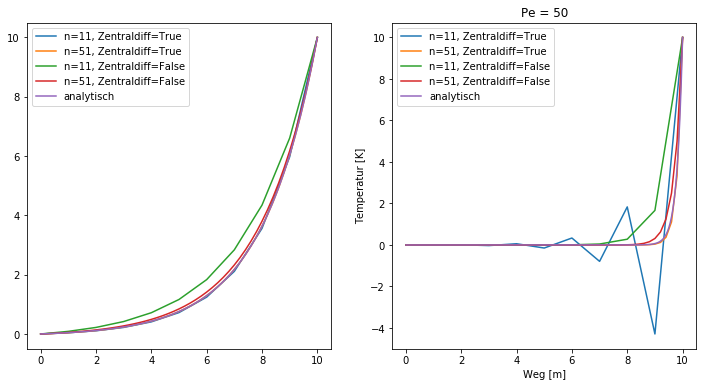

In [6]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax = ax1
for solution in np.array(loesungen):
    if solution[0] == 50:
        ax = ax2
    if (solution[1] == 11 or solution[1] == 51):
        ax.plot(solution[3], solution[4], label="n={}, Zentraldiff={}".format(solution[1], solution[2]))
plt.xlabel("Weg [m]")
plt.ylabel("Temperatur [K]")
ax1.plot(xan, yan[5], label="analytisch")
ax1.legend()
plt.title("Pe = 5")
ax2.plot(xan, yan[50], label="analytisch")
ax2.legend()
plt.ylabel("Temperatur [K]")
plt.title("Pe = 50")
plt.show()

### Aufgabe 2.4.5

Fehlerberechnung

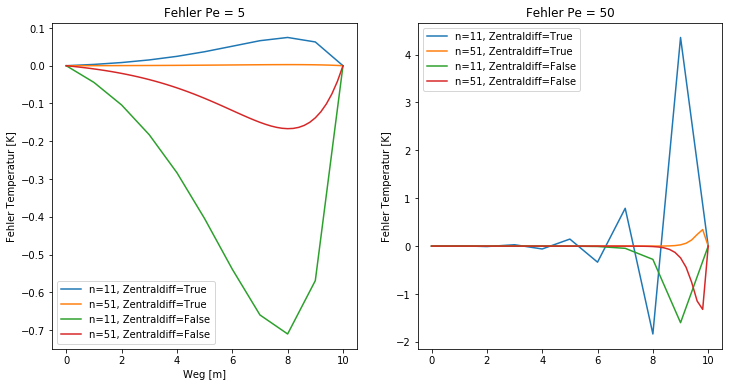

In [7]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1, 2, 1)
plt.xlabel("Weg [m]")
plt.ylabel("Fehler Temperatur [K]")
plt.title("Fehler Pe = 5")
ax2 = plt.subplot(1, 2, 2)
plt.ylabel("Fehler Temperatur [K]")
plt.title("Fehler Pe = 50")
ax = ax1
for solution in np.array(loesungen):
    if solution[0] == 50:
        ax = ax2
    if (solution[1] == 11 or solution[1] == 51):
        ax.plot(solution[3], solution[5], label="n={}, Zentraldiff={}".format(solution[1], solution[2]))
    ax.legend()
plt.show()

_Erklärung_ (gehört zu __2.4.6__)

Deutlich erkennbar: Aufwind-Verfahren hat einen Abbruchterm 2. Ordnung, der genauso wie ein diffusiver Term aussieht (numerische Diffusion). Hohe Temperaturen "diffundieren" für wenige Knoten also stärker (negativer Fehler).

Für das Zentraldifferenzenverfahren könnten bei niedrigen Knotenzahlen und hohen Pe-Zahlen Oszillationen um die analytische Lösung auftreten.

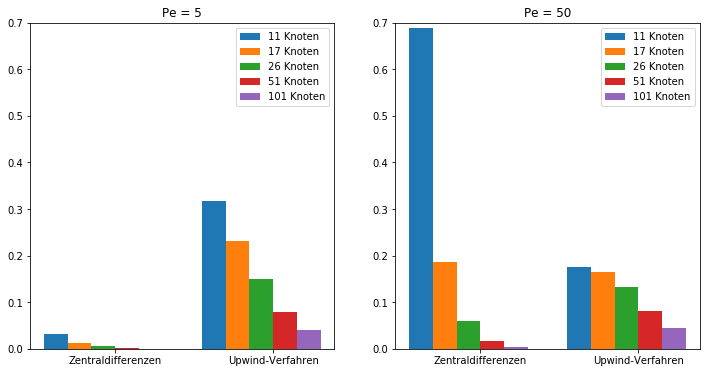

In [8]:
loesungen = np.array(loesungen)
plt.figure(figsize=(12,6))
horizontal = np.array(range(0, 2))
counter = 0
index = 0
bar_width = 0.15
for Pe in [5, 50]:
    index = index + 1
    peloesungen = loesungen[np.where(loesungen[:,0]==Pe)]
    ax = plt.subplot(1, 2, index)
    ax.set_ylim([0,0.7])
    plt.title("Pe = {}".format(Pe))
    knotencounter = 0
    for knoten in knotenzahlen:
        kloesungen = peloesungen[np.where(peloesungen[:,1]==knoten)]
        print
        plt.bar([h + bar_width * knotencounter for h in horizontal], kloesungen[:,6], bar_width, label="{} Knoten".format(knoten))
        plt.legend()
        plt.xticks(horizontal + [bar_width * len(knotenzahlen) / 2] *2, ("Zentraldifferenzen", "Upwind-Verfahren"))
        knotencounter = knotencounter +1